In [1]:
using DrWatson
@quickactivate "FenrirForNeuro"
using CairoMakie
using CSV, DataFrames
using Printf
using Statistics, LinearAlgebra
using ModelingToolkit, FenrirForNeuro, OrdinaryDiffEq

Axis = CairoMakie.Axis

Makie.Axis

In [2]:
# helpers
function import_csvs(path, fnames, header=nothing)
    dfs = []
    for fname in fnames
        fpath = joinpath(path, fname)
        df = CSV.read(fpath, DataFrame, header=false)
        if header != nothing
            rename!(df, header)
        end
        df[!, :iter] = 1:size(df, 1)
        push!(dfs, df)
    end
    return dfs
end

d_norm(X, y) = sqrt.(sum(((X .- y) ./ y) .^ 2, dims=[2]))

function val_at(p, x, y)
    idx = argmin(abs.(x .- p))
    return y[idx]
end

keys(θ) = map(θᵢ -> Symbol(θᵢ[1]), θ)
values(θ) = map(θᵢ -> θᵢ[2], θ)

values (generic function with 1 method)

In [3]:
HALF_WIDTH = ((6.75 - 0.25) / 2) # inches
FULL_WIDTH = 6.75 # inches
HEIGHT = 0.7 * HALF_WIDTH # inches

PT_PER_INCH = 72
HALF_WIDTH *= PT_PER_INCH
FULL_WIDTH *= PT_PER_INCH
HEIGHT *= PT_PER_INCH

RESULTS_PATH = "../../results/"
FIGURES_PATH = "../../figures/"

PLOT_DEFAULTS = (titlesize=7, xlabelsize=7, ylabelsize=7, xticklabelsize=7, yticklabelsize=7, xticksize=2, yticksize=2)

(titlesize = 7, xlabelsize = 7, ylabelsize = 7, xticklabelsize = 7, yticklabelsize = 7, xticksize = 2, yticksize = 2)

In [4]:
p_str = "l"
fpath = RESULTS_PATH*"pd/1p/single_pendulum/fenrir/loss_$p_str/pd-1p-single_pendulum-fenrir-loss_$p_str-1-100.csv"

T(t::Real)::Float64 = 10.0^(20.0 - t)
tempering_schedule = T.(LinRange(0, 20, 21))
header = [p_str, [@sprintf("%.0e", κ²) for κ² in tempering_schedule]...]
loss_surface = CSV.read(fpath, DataFrame, header=header)

Row,l,1e+20,1e+19,1e+18,1e+17,1e+16,1e+15,1e+14,1e+13,1e+12,1e+11,1e+10,1e+09,1e+08,1e+07,1e+06,1e+05,1e+04,1e+03,1e+02,1e+01,1e+00
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.1,3792.41,2647.26,1553.75,777.637,595.19,1048.34,4377.97,21832.0,77968.9,1.25223e5,1.38119e5,1.4316e5,1.44996e5,1.45251e5,1.45277e5,145280.0,1.4528e5,1.4528e5,1.4528e5,1.4528e5,1.4528e5
2,0.2,3616.25,2472.43,1390.57,661.273,490.615,765.577,2930.13,13003.7,40095.0,62729.0,71024.7,74521.8,75193.9,75268.2,75275.7,75276.5,75276.6,75276.6,75276.6,75276.6,75276.6
3,0.3,3553.01,2409.6,1331.27,615.508,444.094,639.837,2368.94,10061.3,28048.3,42920.8,49268.5,51458.7,51779.5,51813.2,51816.6,51816.9,51817.0,51817.0,51817.0,51817.0,51817.0
4,0.4,3520.27,2377.05,1300.38,591.337,422.777,585.153,2057.52,8698.48,22998.4,34410.7,39674.4,41250.3,41456.9,41478.2,41480.3,41480.6,41480.6,41480.6,41480.6,41480.6,41480.6
5,0.5,3500.71,2357.59,1281.75,575.935,407.279,542.03,1827.74,7501.09,18678.9,28055.6,32575.0,33683.6,33816.8,33830.4,33831.7,33831.9,33831.9,33831.9,33831.9,33831.9,33831.9
6,0.6,3487.2,2344.14,1268.81,565.101,396.773,513.072,1704.31,7240.29,17550.1,24730.1,27404.7,27945.7,28007.6,28013.8,28014.5,28014.5,28014.5,28014.5,28014.5,28014.5,28014.5
7,0.7,3477.7,2334.67,1259.61,556.93,386.784,474.46,1453.54,5988.81,14448.9,21722.4,25119.7,25791.7,25867.0,25874.6,25875.4,25875.5,25875.5,25875.5,25875.5,25875.5,25875.5
8,0.8,3470.64,2327.64,1252.8,551.094,381.626,459.697,1362.73,5910.76,14479.5,20999.0,23458.0,23876.8,23922.4,23927.0,23927.5,23927.5,23927.5,23927.5,23927.5,23927.5,23927.5
9,0.9,3464.76,2321.77,1247.09,546.073,376.83,445.113,1260.0,5344.52,12345.0,16816.5,18508.5,18799.3,18830.9,18834.1,18834.4,18834.5,18834.5,18834.5,18834.5,18834.5,18834.5


In [5]:
fpath = RESULTS_PATH*"pd/1p/single_pendulum/fenrir/tempered_diff/"
fnames = [name for name in readdir(fpath)]
trajectories = import_csvs(fpath, fnames, [Symbol(p_str), :κ², :loss, :T])

trajectories_at_κ² = []
for trajectory in trajectories
    trajectory_at_κ² = [trajectory[log.(trajectory[!, :κ²]).==log.(κ²), :] for κ² in tempering_schedule]
    push!(trajectories_at_κ², trajectory_at_κ²)
end

In [6]:
@parameters l φ₀
θ = [l => 3]
prob_prior, prob = get_Pendulum(θ)
proj = [1 0]
observation = generate_data(prob, proj, 0, 1e-2)

(t = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99, 10.0], u = [[0.0], [-0.02312150065048962], [-0.04623765423421778], [-0.06934311120711166], [-0.092432517115431], [-0.1155005101130485], [-0.13854171856232173], [-0.1615507587029178], [-0.18452223223086292], [-0.20745072406831275]  …  [1.382358903948816], [1.383359928020525], [1.3839087400001395], [1.384005055411185], [1.383648824266751], [1.3828402312324697], [1.3815796953416322], [1.3798678692311945], [1.3777056380921902], [1.3750941182700502]])

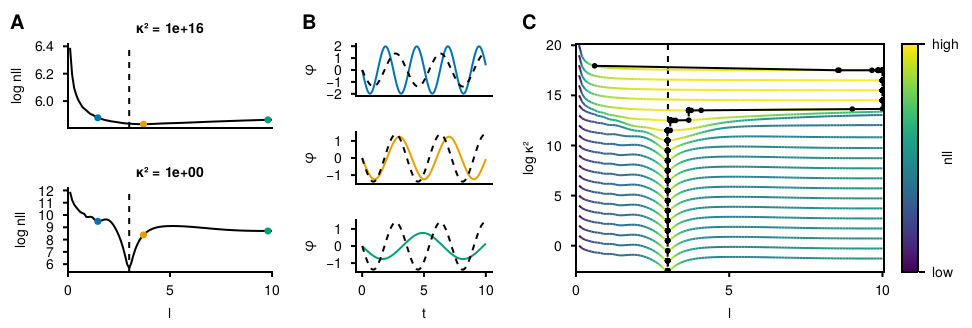

In [11]:
p = loss_surface[:, p_str]
idxs = [5,21]

min_high_diff = p[argmin(log.(loss_surface[:, 1+idxs[1]]))]
points_of_interest = [1.46, min_high_diff, 9.8]

f = Figure(size=(FULL_WIDTH, HEIGHT), figure_padding=(5,10,5,5))
nll_axes = f[1, 1] = GridLayout()
ode_axes = f[1, 2] = GridLayout()
opt_axes = f[1, 3] = GridLayout()

left_axes = []
for (i, idx) in enumerate(idxs)
    ax = Axis(nll_axes[i, 1], xlabel=p_str, ylabel="log nll", title=@sprintf("κ² = %.0e", tempering_schedule[idx]); PLOT_DEFAULTS...)
    lines!(ax, p, log.(loss_surface[:, 1+idx]), color=:black, linewidth=1, linestyle=:solid, label=header[idx])
    vlines!(ax, [3], color=:black, linewidth=1, linestyle=:dash, label="true")
    xlims!(ax, (0.0, 10))
    hidespines!(ax, :r, :t)
    hidedecorations!(ax, grid=true, label=false, ticks=false, ticklabels=false)
    push!(left_axes, ax)
end
scatter!(left_axes[1], points_of_interest, [val_at(pᵢ, p, log.(loss_surface[:, 1+idxs[1]])) for pᵢ in points_of_interest], color=Makie.wong_colors()[1:3], label=header[idxs[1]], markersize=5)
scatter!(left_axes[2], points_of_interest, [val_at(pᵢ, p, log.(loss_surface[:, 1+idxs[2]])) for pᵢ in points_of_interest], color=Makie.wong_colors()[1:3], label=header[idxs[2]], markersize=5)
hidexdecorations!(left_axes[1])
linkxaxes!(left_axes...)


middle_axes = []
for (i, (l, c)) in enumerate(zip(points_of_interest, Makie.wong_colors()[1:3]))
    ax = Axis(ode_axes[i, 1], xlabel="t", ylabel="φ", titlesize=7, xlabelsize=7, ylabelsize=7, xticklabelsize=7, yticklabelsize=7, xticksize=2, yticksize=2)
    data = generate_data(remake(prob, p=[l]), proj, 0, 1e-2)
    lines!(ax, data.t, vcat(data.u...), linewidth=1, linestyle=:solid, color=c)
    lines!(ax, observation.t, vcat(observation.u...), linewidth=1, linestyle=:dash, label="true", color=:black)
    if length(middle_axes) > 0
        linkxaxes!(middle_axes[1], ax)
    end
    hidespines!(ax, :r, :t)
    hidedecorations!(ax, grid=true, label=false, ticks=false, ticklabels=false)
    push!(middle_axes, ax)
end

hidexdecorations!.(middle_axes[1:2], label=true, ticks=true, ticklabels=true)

p = loss_surface[:, p_str]

pad = 0.4
ls = log.(Array(loss_surface[:, 2:end]))
max_ls, min_ls = maximum(ls, dims=1), minimum(ls, dims=1)
yticks = 1 .- (ls[1, :] .- min_ls[1, :]) ./ (max_ls[1, :] .- min_ls[1, :]) + (collect(0:20) * pad)
# yticklabels = [@sprintf("%.0e", κ²) for κ² in tempering_schedule]
yticklabels = [@sprintf("%.0f", log10(κ²)) for κ² in tempering_schedule]

ax = Axis(opt_axes[1, 1], ylabel="log κ²", xlabel=p_str, yticks=(yticks[1:5:end], yticklabels[1:5:end]), yreversed=true; PLOT_DEFAULTS...)
vlines!(ax, [3], color=:black, linewidth=1, linestyle=:dash, label="true")

prev_endpoint = nothing
for (i, T) in enumerate(tempering_schedule)
    log_nll = log.(loss_surface[:, 1+i])
    rescale(l) = (l .- minimum(log_nll)) ./ (maximum(log_nll) - minimum(log_nll))
    flip(l) = 1 .- l
    add_padding(l) = l .+ (pad * (i - 1))

    norm_log_nll = rescale(log_nll)
    norm_log_nll = flip(norm_log_nll)
    padded_log_nll = add_padding(norm_log_nll)

    # lines!(ax, padded_log_nll, p, color=:black, linewidth=1, linestyle=:solid, label=header[i+1])
    lines!(ax, p, padded_log_nll, color=norm_log_nll, colormap=:viridis, colorrange=[minimum(norm_log_nll), maximum(norm_log_nll)], linewidth=1, linestyle=:solid, label=header[i+1])

    for (k, trajectory_at_κ²) in enumerate(trajectories_at_κ²[7:7])
        t = trajectory_at_κ²[i]
        norm_t_loss = (log.(Array(t[!, :loss])) .- minimum(log_nll)) / (maximum(log_nll) - minimum(log_nll))
        norm_t_loss = flip(norm_t_loss)
        log_t_loss = add_padding(norm_t_loss)

        if size(t, 1) > 1
            lines!(ax, Array(t[!, p_str]), log_t_loss, color=:black, label="T=$(T)", linewidth=1)
            scatter!(ax, Array(t[!, p_str]), log_t_loss, color=:black, label="T=$(T)", markersize=4)

            if prev_endpoint != nothing
                lines!(ax, [prev_endpoint[2], t[1, p_str]], [prev_endpoint[1], log_t_loss[1]], linewidth=1, linestyle=:dash, color=:black)
            end
            prev_endpoint = [log_t_loss[end], t[end, p_str]]
        end
    end


    # hidexdecorations!(ax)
    xlims!(ax, (0, 10 + 0.05))
    ylims!(ax, (pad * length(tempering_schedule) + (1 - pad) + 0.05, -0.05))
    hidedecorations!(ax, grid=true, label=false, ticks=false, ticklabels=false)

end
cbar = Colorbar(opt_axes[1, 2], label="nll", ticklabelsize=7, limits=(0, 1), labelsize=7, ticks=([0, 1], ["low", "high"]), size=8, ticksize=3, labelpadding=-10)
colgap!(opt_axes, 1, Relative(0.05))


colsize!(f.layout, 1, Relative(0.3))
colsize!(f.layout, 2, Relative(0.2))
colgap!(f.layout, Relative(0.04))

Label(f.layout[1, 1, TopLeft()], "A", fontsize=10, font=:bold, padding=(0, 5, 5, 0), halign=:left)
Label(f.layout[1, 2, TopLeft()], "B", fontsize=10, font=:bold, padding=(0, 5, 5, 0), halign=:left)
Label(f.layout[1, 3, TopLeft()], "C", fontsize=10, font=:bold, padding=(0, 5, 5, 0), halign=:left)

f

In [12]:
save(joinpath(FIGURES_PATH, "figure3.pdf"), f, overwrite=true)

CairoMakie.Screen{PDF}
